### We try to use a gaussian distribution up to 6 beam sigma_x of SSC. 
- We consider round beam
- Twiss parameters are included in the rotation
- Motion restricted in the H plane. This means that y,py =0. x, px are given initial values. px0 is set to 0 for simplicity. 
- The elements, the machine and the functions are imported from utils.
- In this case the initial distribution is imported from the folder ./my_distributions

In [14]:
import os
import sys
import numpy as np
from math import *
import pandas as pd
import random
import matplotlib.pyplot as plt
from dotted_dict import DottedDict
import NAFFlib as pnf
sys.path.append('./utils')
from my_elements import *
from my_machines import *
from my_functions import *

### Plotting parameters

In [15]:
params = {'legend.fontsize': 25,
          'figure.figsize': (8.5, 6.5),
          'axes.labelsize': 25,
          'axes.titlesize': 25,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'image.cmap': 'jet',
          'lines.linewidth': 1,
          'lines.markersize': 5,
          'font.family': 'sans-serif'}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

In [16]:
def standard_V_CC(E_0, c, cc, y, py, z, delta):
    
    y1 = y
    k = 2 * np.pi * cc.f_CC / c # wavenumber of the cavity
    py1 = cc.V_CC * np.sin(cc.ps + k * z)/E_0
    z1 = z
    delta1 = delta       
                    
    return y1, py1, z1, delta1

### Input of the prep_RF function
- given by the user, (config.json file)

In [17]:
# constants
m0 = 0.9382720813e9 # proton rest mass, [eV/c^2] 
c = 299792458 # speed of light [m/s]

In [18]:
C0 = 26658.8832 # LHC circumference MAD-X twiss, [m]   , alternively use 26659 [m]
E_0 = 7000.*1e9 # total energy of the reference particle [eV]
gamma_tr =  53.7102749510076 # MAD-X twiss
sigma_delta_madx = 0.00011 # [m] rms relative momentum spread, from mad-x  cernbox/2019/7/HL_LH_mask_emilia.ipynb.
  

### Parameters of the RF cavity
- given by the user, (config.json file)

In [19]:
rf = DottedDict()
rf.V_RF = 16e6 #[V]
rf.lag = 180.#  the lag angle of the cavity [degrees], also known as phi_RF. If set up properly phi_RF = phi_s (synchronous phase) 
rf.f_RF = 400.8e6 # Hz

### Parameters of the CC

In [24]:
cc = DottedDict()
cc.V_CC = 16e6 # [V]
cc.ps = 0.#  the lag angle of the cavity [degrees], also known as phi_RF. If set up properly phi_RF = phi_s (synchronous phase) 
cc.f_CC = 400e6 # Hz

### Define the machine parameters
- The parameters here correspond to HL-LHC. Obtained from MAD-X. They should be crosschecked. 

In [25]:
f_rev = c/C0  # revolution frequency [Hz]

# Relativistic parameters
gamma_rel = 7460.52252807237 # from madx twiss
beta_rel = sqrt(1-(1/gamma_rel)**2)
# Twiss parameters
twiss = DottedDict()
twiss.beta_x = 115.75 #122.84 
twiss.beta_y = 115.75 #218.54 
twiss.alpha_x = 0 
twiss.alpha_y = 0 
twiss.gamma_x = (1+twiss.alpha_x**2)/twiss.beta_x
twiss.gamma_y = (1+twiss.alpha_y**2)/twiss.beta_y

In [26]:
Qx_init = 2*pi*62.775
Qy_init = 2*pi*62.775

### Define the study parameters

In [27]:
turns = 500
particles = 1000
ex_norm = 2.5e-6 # [m]
ey_norm = 2.5e-6 /1e6
max_aperture_value = 100 #3e-2 # ~ radius of LHC vaccume chamber

### Calculate beam sigma in [m]

\begin{equation}
\sigma = \sqrt{e_{geom}\beta(s)} \\
e_{geom} = \frac{e_{norm}}{\beta_{rel}\gamma_{rel}}
\end{equation}


In [28]:
# H plane
ex_geom = ex_norm/(beta_rel*gamma_rel)
sigma_x = sqrt(twiss.beta_x*ex_geom)
sigma_px = sqrt(ex_geom/twiss.beta_x)
print("sigma_x = {} [m] \nsigm_px = {} [m]".format(sigma_x, sigma_px))
# V plane
ey_geom = ey_norm/(beta_rel*gamma_rel)
sigma_y = sqrt(twiss.beta_y*ey_geom)
sigma_py = sqrt(ey_geom/twiss.beta_y)
print("sigma_y = {} [m] \nsigm_py = {} [m]".format(sigma_y, sigma_py))

sigma_x = 0.00019694541882215593 [m] 
sigm_px = 1.7014723008393603e-06 [m]
sigma_y = 1.9694541882215596e-07 [m] 
sigm_py = 1.7014723008393605e-09 [m]


### Prepare the longitudinal motion

In [29]:
long_motion_parameters = prepere_longitudinal_motion(m0, c, C0, E_0, gamma_tr, sigma_delta_madx, rf)
long_motion_parameters.E_0 = E_0
long_motion_parameters.m0 = m0
long_motion_parameters.C0 = C0
long_motion_parameters.c = c


### Create the initial distribution and do sanity checks
- Gaussian in both x and px, with sigma_x and sigma_px respsectively
- Sanity checks: 
    1. Plot beam profiles
    2. Compute normalised emiitance
    3. Plot phase space

In [30]:
df_test = pd.read_pickle('initial_long_distribution.pkl')

In [31]:
bunch = create_bunch(particles)

mu, sigma = 0.0, 1 # mean and standard deviation

x_initial = np.random.normal(mu, sigma, particles)*sigma_x
px_initial = np.random.normal(mu, sigma, particles)*sigma_px
y_initial = np.random.normal(mu, sigma, particles)*sigma_y
py_initial = np.random.normal(mu, sigma, particles)*sigma_py
z_initial = np.random.normal(mu, sigma, particles)*long_motion_parameters.sigma_z
delta_initial = np.random.normal(mu, sigma, particles)*long_motion_parameters.sigma_delta
#z_initial = np.array(df_test['z'][0])
#delta_initial = np.array(df_test['delta'][0])

bunch.x = x_initial
bunch.px = px_initial
bunch.y = y_initial
bunch.py = py_initial
bunch.z = z_initial
bunch.delta = delta_initial

#### Plot beam profiles

Text(0.5, 1.0, 'Angle')

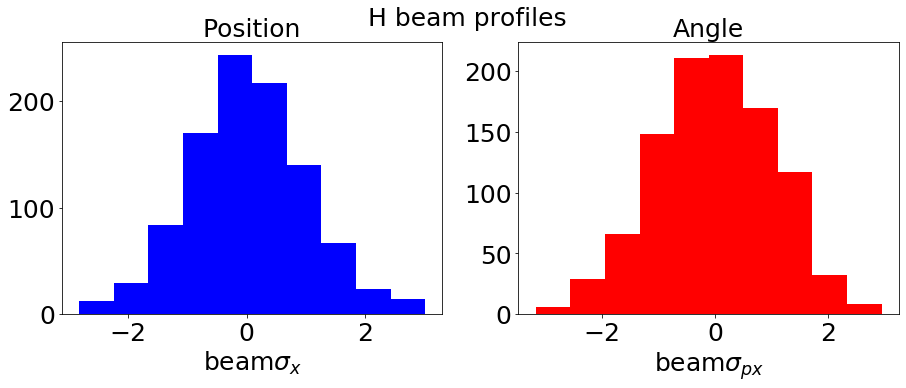

In [32]:
f = plt.figure(figsize=(15,5))
f.suptitle('H beam profiles', fontsize = 25)
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)


ax.hist(x_initial/sigma_x, color = 'b')
ax.set_xlabel('beam'+r'$\sigma_{x}$')
ax.set_title('Position')
ax2.hist(px_initial/sigma_px, color = 'r')
ax2.set_xlabel('beam'+r'$\sigma_{px}$')
ax2.set_title('Angle')

Text(0.5, 1.0, 'Angle')

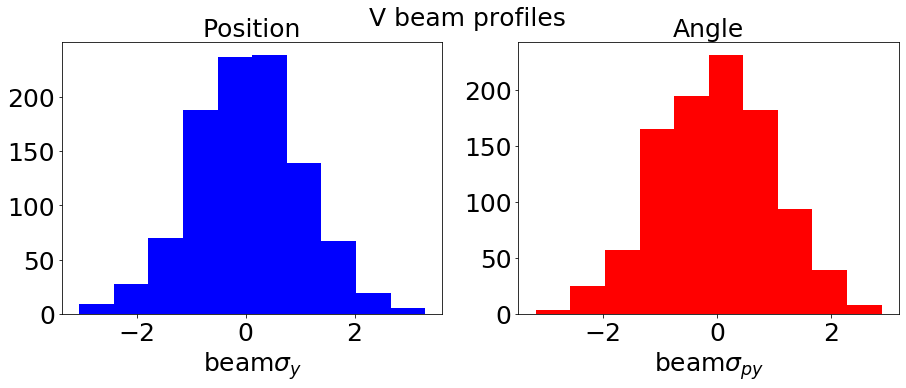

In [33]:
f = plt.figure(figsize=(15,5))
f.suptitle('V beam profiles', fontsize = 25)
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)


ax.hist(y_initial/sigma_y, color = 'b')
ax.set_xlabel('beam'+r'$\sigma_{y}$')
ax.set_title('Position')
ax2.hist(py_initial/sigma_py, color = 'r')
ax2.set_xlabel('beam'+r'$\sigma_{py}$')
ax2.set_title('Angle')

Text(0.5, 1.0, 'Angle')

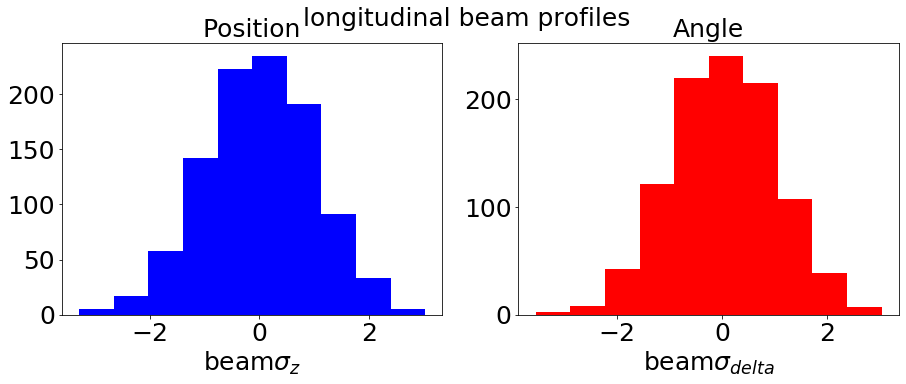

In [34]:
f = plt.figure(figsize=(15,5))
f.suptitle('longitudinal beam profiles', fontsize = 25)
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)


ax.hist(z_initial/long_motion_parameters.sigma_z, color = 'b')
ax.set_xlabel('beam'+r'$\sigma_{z}$')
ax.set_title('Position')
ax2.hist(delta_initial/long_motion_parameters.sigma_delta, color = 'r')
ax2.set_xlabel('beam'+r'$\sigma_{delta}$')
ax2.set_title('Angle')

#### Plot phase space

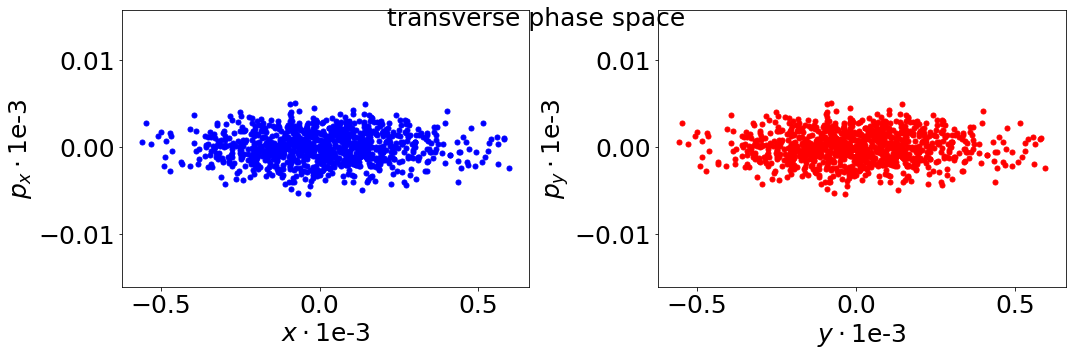

In [35]:
f = plt.figure(figsize=(15,5))
f.suptitle('transverse phase space', fontsize = 25)
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)


ax.scatter(bunch.x*1e3, bunch.px*1e3, color = 'b')
ax.set_xlabel(r'$x \cdot $1e-3')
ax.set_ylabel(r'$p_x \cdot $1e-3')
ax2.scatter(bunch.x*1e3, bunch.px*1e3,  color = 'r')
ax2.set_xlabel(r'$y \cdot $1e-3')
ax2.set_ylabel(r'$p_y \cdot $1e-3')

plt.tight_layout()

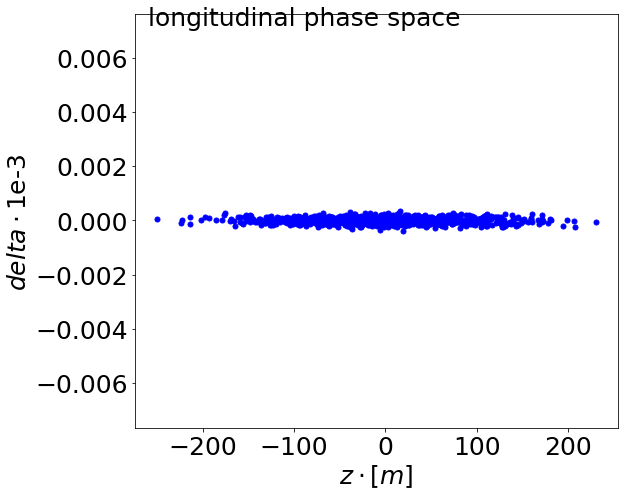

In [36]:
fig, ax = plt.subplots(1,1,figsize=(9,7))
fig.suptitle('longitudinal phase space', fontsize = 25)

ax.scatter(bunch.z*1e3, bunch.delta, color = 'b')
ax.set_xlabel(r'$z \cdot [m]$')
ax.set_ylabel(r'$delta \cdot $1e-3 ')
plt.tight_layout()

#### Calculate emittance

In [37]:
e_x = cmp_emit(bunch.x, bunch.px)
print('H normalised emittance',e_x*beta_rel*gamma_rel)
print('H geometric emittance',e_x)

e_y = cmp_emit(bunch.y, bunch.py)
print('V normalised emittance',e_y*beta_rel*gamma_rel)
print('V geometric emittance',e_y)

H normalised emittance 2.6335987306103977e-06
H geometric emittance 3.530045977823793e-10
V normalised emittance 2.5115105652086304e-12
V geometric emittance 3.3664003805628516e-16


### Define the configuration of the machine
- Set "True" the flags for the elements you want to use
- Note that whent the detuner is used, the user shold give the strength of the octupole that would result to the same tune shift (this is due to the way the detuner is defined in this model).

In [38]:
flag_oct = False
flag_noise = False
flag_BB = False
flag_feedback = False
flag_detuner = False
k3 = 5825.61 #1.
if flag_detuner:
    k3_equivalent_x = k3 # Difference between x and y 
    k3_equivalent_y = 0.
segments = 8
Delta = 0.1 # normalised in beam sigma , xaviers
ksi = 0.01 # the normalisation in beam sigma , is done in the respective function in ./utiles/my_elements.py
gain = 0.2
elements_list = [flag_oct, flag_noise, flag_BB, flag_feedback, flag_detuner]
elements_list_str = ['oct', 'noise', 'BB', 'feedback', 'detuner']
study_name = ''
for index,element in enumerate(elements_list):
    if element == True:
        study_name = study_name + elements_list_str[index]+ '_'
print(study_name)

#### If the detuner is on, you can do a sanity check whether the phase advance that it will introduce will generate the wanted tune spread

In [39]:
if flag_detuner:
    f = plt.figure(figsize=(15,5))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    dqx, dqy = amplitude_detuning(k3_equivalent_x, k3_equivalent_y, twiss, x= bunch.x, px = bunch.px, y = bunch.y, py= bunch.py)
    
    jx=((bunch.x/sqrt(twiss.beta_x))**2+(bunch.px*sqrt(twiss.beta_x))**2)/2.
    jy=((bunch.y/sqrt(twiss.beta_y))**2+(bunch.py*sqrt(twiss.beta_y))**2)/2.
    
    
    ax.plot(jx, dqx, '.')
    ax.set_xlabel(r'$J_x$')
    ax.set_ylabel('total tune shift')
    ax2.plot(jy, dqy, '.')
    ax2.set_xlabel(r'$J_y$')
    ax2.set_ylabel('total tune shift')

### Initialise data frame to save the turn by turn data

In [40]:
df = pd.DataFrame({'turn':[], 'x':[], 'px':[], 'y':[], 'py':[], 'z':[], 'delta':[]})
# Append the initial values, not normalised
df = df.append({'turn':0, 'x':bunch.x, 'px':bunch.px, 'y':bunch.y, 'py':bunch.py, 'z':bunch.z, 'delta':bunch.delta}, ignore_index = True)

In [41]:
jx=((bunch.x/twiss.beta_x)**2+(bunch.px*twiss.beta_x)**2)/2.
max(jx)

1.9586577147488985e-07

### Tracking

flag_oct False, flag_noise False, flag_BB False, flag_feedback False
aperture limit is 100 [m]


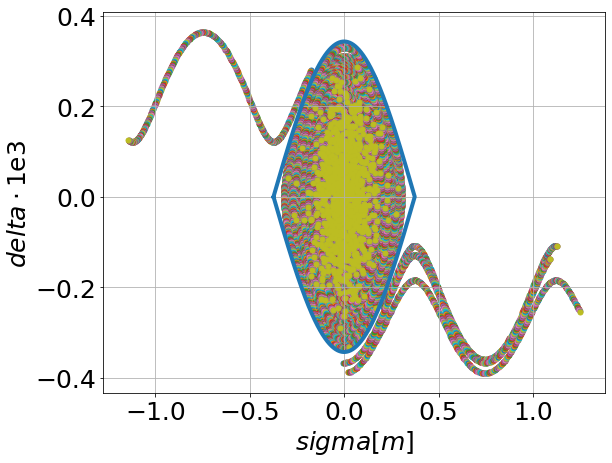

In [42]:
fig, ax = plt.subplots(1,1,figsize=(9,7))


# Re-initialise the bunch as the initial coordinates were used in the iteration above
bunch.x = x_initial 
bunch.px = px_initial
bunch.y = y_initial
bunch.py = py_initial
bunch.z = z_initial
bunch.delta = delta_initial
# Create the data frame to save the distribution
df = pd.DataFrame({'x':[], 'px':[], 'y':[], 'py':[]})
df = df.append({'x':bunch.x, 'px':bunch.px, 'y':bunch.y, 'py':bunch.py}, ignore_index = True) # append the initial values (turn 0)

for turn in range(1, turns): #we start from turn 1 as we have already include the intiial conditions (turn 0)
    ax.scatter(bunch.z, bunch.delta*1e3)
    if flag_detuner:
        bunch = my_machine_with_detuners(Qx_init, Qy_init, k3_equivalent_x, k3_equivalent_y, turn, bunch, twiss, rf, long_motion_parameters, flag_detuner, flag_noise,flag_BB, flag_feedback, max_aperture_value, Delta, ksi, gain, sigma_x, sigma_px, sigma_y, sigma_py)
    else:
        bunch = my_machine(Qx_init, Qy_init, segments, k3, turn, bunch, twiss, rf, long_motion_parameters, flag_oct, flag_noise,flag_BB, flag_feedback, max_aperture_value, Delta, ksi, gain, sigma_x, sigma_px, sigma_y, sigma_py)
        bunch.y, bunch.py, bunch.z, bunch.delta = standard_V_CC(E_0, c, cc, bunch.y, bunch.py, bunch.z, bunch.delta)
    df = df.append({'turn':turn, 'x':bunch.x, 'px':bunch.px, 'y':bunch.y, 'py':bunch.py, 'z':bunch.z, 'delta':bunch.delta}, ignore_index = True)
    
    #plt.legend()

    

ax.set_xlabel(r'$sigma [m]$')
ax.set_ylabel(r'$delta \cdot $1e3')

# RF bucket
step = 0.001
z_list = []
delta_list = []

z_left, z_right = get_rf_bucket(c, long_motion_parameters.beta_0, long_motion_parameters.eta,  long_motion_parameters.h, E_0, rf)

for zi in np.arange(z_left , z_right , step):
    delta_list.append(np.sqrt(rf.V_RF * (np.cos(long_motion_parameters.h * zi * 2 * np.pi / C0) + 1.) / (np.pi * long_motion_parameters.h * abs(long_motion_parameters.eta) * long_motion_parameters.beta_0 * long_motion_parameters.P0_C)))
    z_list.append(zi)
                      
for zi in np.arange(z_right, z_left , -step):
    delta_list.append(-np.sqrt(rf.V_RF * (np.cos(long_motion_parameters.h * zi * 2 * np.pi / C0) + 1.) / (np.pi * long_motion_parameters.h * abs(long_motion_parameters.eta) * long_motion_parameters.beta_0 * long_motion_parameters.P0_C)))
    z_list.append(zi)

ax.plot(z_list, np.array(delta_list)*1e3, linewidth =4)
plt.grid()



    
#df.to_pickle('{}betax{}_betay{}_H_V_particles{}_turns{}.pkl'.format(study_name, twiss.beta_x,twiss.beta_y, particles,turns))

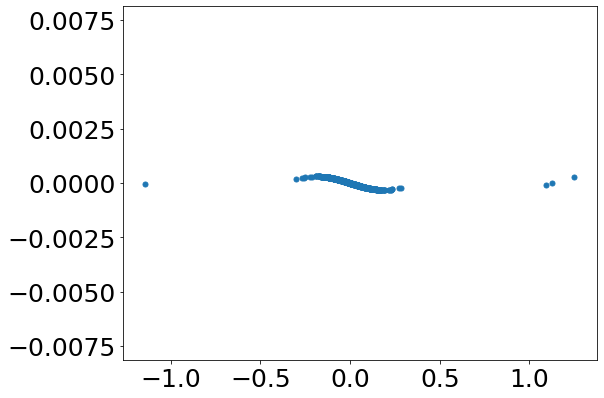

In [43]:
plt.scatter(df['z'][499], df['y'][499], label ='simulation results')

# Compare with theory

In [81]:
n_particles = 1000.
start, stop = -1.0, 1.0
step = (stop-start)/n_particles
initial_sigmas = np.arange(start, stop, step)

In [82]:
# the locationof the cc and the distrotion is the same, one beta function
beta_y = 115.75
muy= 0.

In [90]:
k = 2 * np.pi * cc.f_CC / c # wavenumber of the cavity
#delta_py_CC = cc.V_CC * np.sin(cc.ps + k * np.array(initial_sigmas))/E_0
delta_py_CC = cc.V_CC * np.sin(cc.ps + k * initial_sigmas)/E_0

In [94]:
Qy = 62.775

In [95]:
y_co_CC = (np.sqrt(beta_y*beta_y)) * np.array(delta_py_CC)*np.cos(2*np.pi*muy - np.pi*Qy)/ (2*np.sin(np.pi*Qy)) 

(-0.001, 0.001)

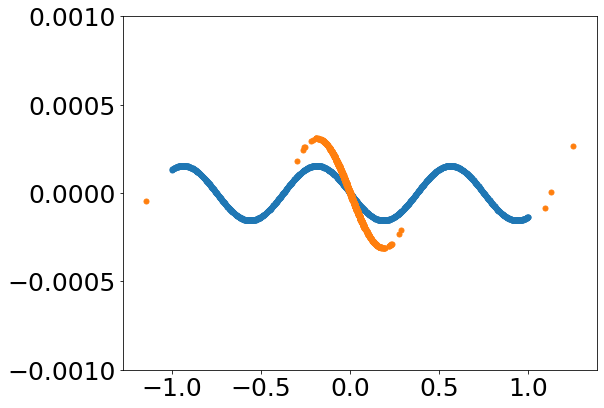

In [96]:
plt.scatter(initial_sigmas, y_co_CC)
plt.scatter(df['z'][499], df['y'][499], label ='simulation results')
plt.ylim(-0.001, 0.001)


### Calculate tune shift with amplitude (Jx)
- We need to store the data in groups of particles. 
- In our data frames are in groups of turns
- Calculate Jx

In [79]:
x_data = {}
px_data = {}
y_data = {}
py_data = {}
for particle in range(particles):
    x_data[particle] = []
    px_data[particle] = []
    y_data[particle] = []
    py_data[particle] = []

In [80]:
for particle in range(particles):
    for turn in range(turns):
        x_data[particle].append(df.at[turn,'x'][particle])
        px_data[particle].append(df.at[turn,'px'][particle])
        y_data[particle].append(df.at[turn,'y'][particle])
        py_data[particle].append(df.at[turn,'py'][particle])

KeyboardInterrupt: 

In [ ]:
lost_particles = []
Qx_list = []
Qy_list = []

for particle in range(particles):
    if np.isnan(x_data[particle]).any() or np.isnan(px_data[particle]).any():
        lost_particles.append(particle)
        print('particle {} lost'.format(particle))
    else:        
        signal_x = x_data[particle]  
        signal_y = y_data[particle] 

        Qx_list.append(pnf.get_tune(np.array(signal_x)))
        if not y_initial[0] == 0:
            Qy_list.append(pnf.get_tune(np.array(signal_y)))

### Use normalised coordiantes (same applies for y)
\begin{equation}
x_{N} = \frac{x}{\sqrt{\beta(s)}} \\
px_{N} = px \cdot \sqrt{\beta(s)}
\end{equation}

### Calculate initial actions Jx (same applies for y)
\begin{equation}
J_x = \frac{x_{N}^2 + px_{N}^2}{2} 
\end{equation}

In [25]:
x_norm = df.at[0,'x']/sqrt(twiss.beta_x) # the index 0 corresponds to turn
px_norm = df.at[0,'px']*sqrt(twiss.beta_x)
Jx_initial = (x_norm**2 + px_norm**2)/2.

y_norm = df.at[0,'y']/sqrt(twiss.beta_y) # the index 0 corresponds to turn
py_norm = df.at[0,'py']*sqrt(twiss.beta_y)
Jy_initial = (y_norm**2 + py_norm**2)/2.

In [26]:
print('The maximum initial actions: \nJx ={} \nJy={}'.format(max(Jx_initial), max(Jy_initial)))

The maximum initial actions: 
Jx =3.902400960282116e-09 
Jy=3.3680583314663446e-09


### Calculate the average actions for the first 1000 turns

In [27]:
# the indeces 1, 2 corrsepond to the first and second time integral respectively
flag_average_actions = True
if flag_average_actions:
    Jx_mean = [] # Here you will save the average actions for each particle over the first and last 1000 turns
    Jx_data = {}
    Jy_mean = [] # Here you will save the average actions for each particle over the first and last 1000 turns
    Jy_data = {}
    for particle in range(particles):
        Jx_data[particle] = []
        Jx_data[particle] = (np.array(x_data[particle])/sqrt(twiss.beta_x))**2 + (np.array(px_data[particle])*sqrt(twiss.beta_x))**2
        Jx_mean.append(np.nanmean(Jx_data[particle]))
               
        
        Jy_data[particle] = []
        Jy_data[particle] = (np.array(y_data[particle])/sqrt(twiss.beta_y))**2 + (np.array(py_data[particle])*sqrt(twiss.beta_y))**2
        Jy_mean.append(np.nanmean(Jy_data[particle]))

In [28]:
print('The maximum mean actions: \nJx ={} \nJy={}'.format(max(Jx_mean), max(Jy_mean)))

The maximum mean actions: 
Jx =8.39837118042104e-09 
Jy=6.741315605512019e-09


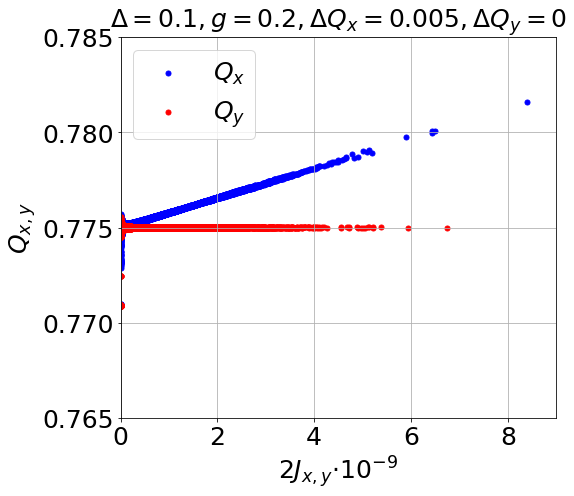

In [57]:
fig, ax = plt.subplots(1,1,figsize=(8,7))

Qx_list_plot = [1-i for i in Qx_list] # 1-i becuase the tune is above 0.5
Qy_list_plot = [1-i for i in Qy_list]

ax.scatter(np.array(Jx_mean)*1e9, Qx_list_plot, c='b', label=r'$Q_x$') 
ax.scatter(np.array(Jy_mean)*1e9, Qy_list_plot, c='r', label=r'$Q_y$') 
ax.set_title(r'$\Delta={}, g={}, \Delta Q_x={:.3f}, \Delta Q_y={}$'.format(Delta, gain, 0.005, 0))
ax.set_xlabel(r'$2J_{x,y}$'+r'$\cdot 10^{-9}$')
ax.set_ylabel(r'$Q_{x,y}$')
ax.set_ylim(0.765, 0.785)
ax.set_xlim(0,9)
ax.grid()

plt.legend()
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('./figures/tune_shift_Qx{}_Qy{}_detunerx{:.3f}_detunery{:.3f}_g{:.3f}_delta{:.3f}_betax{}_betay{}_particles{}_turns{}.png'.format(Qx_init, Qy_init, k3_equivalent_x, k3_equivalent_y, gain, Delta, twiss.beta_x, twiss.beta_y, particles, turns ))

### Emittance growth

In [58]:
e_x = [] # list for the values of geometric emittance over turns
e_y = []
for turn in range(turns):
    e_x.append(cmp_emit(df.at[turn,'x']/sqrt(twiss.beta_x), df.at[turn,'px']*sqrt(twiss.beta_x) ))
    e_y.append(cmp_emit(df.at[turn,'y']/sqrt(twiss.beta_y), df.at[turn,'py']*sqrt(twiss.beta_y) ))

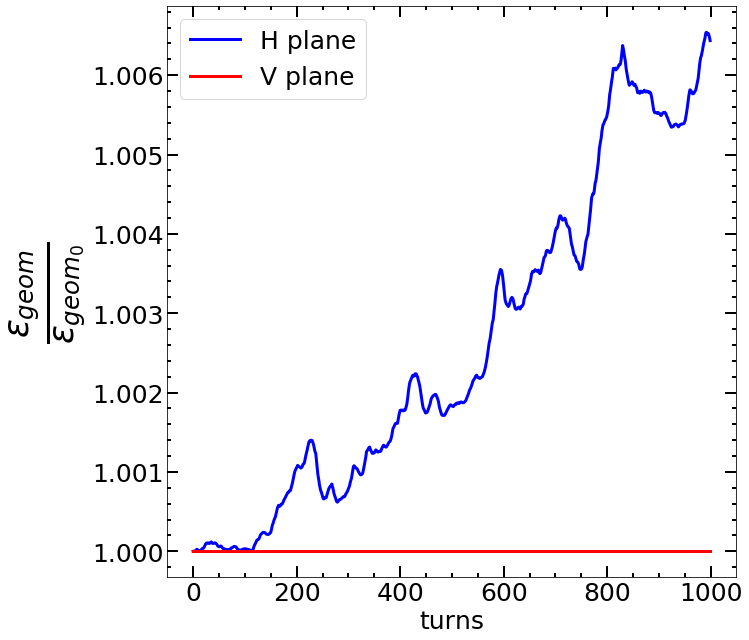

In [62]:
fig, ax = plt.subplots(1,1,figsize=(10.5,9))

ax.plot(e_x/e_x[0], c = 'b', label='H plane', linewidth=3)
ax.plot(e_y/e_y[0], c='r', label='V plane', linewidth=3)

ax.set_xlabel('turns')
ax.set_ylabel(r'$\frac{\epsilon_{geom}}{\epsilon_{geom_0}} $', fontsize = 50)

#ax.set_ylim(0, 40)

# Set the ticks in both sides of the axes
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
# Display minor ticks on the axis
ax.minorticks_on() 


# Set the appearance of the ticks
ax.tick_params(which='both',direction='in', width=2)
ax.tick_params(which='major',direction='in', length=11)
ax.tick_params(which='minor',direction='in', length=4)



# Make axis equal. Note that the size of the figure affects this
ax.set_aspect(aspect='auto')
plt.legend()

#plt.gca().legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
savefig = False
if savefig:
    plt.savefig('./figures/emittance_evolution_Qx{}_Qy{}_detunerx{:.3f}_detunery{:.3f}_g{:.3f}_delta{:.3f}_betax{}_betay{}_particles{}_turns{}.png'.format(Qx_init, Qy_init, k3_equivalent_x, k3_equivalent_y, gain, Delta, twiss.beta_x, twiss.beta_y, particles, turns ))

### test of longitudinal motion